In [1]:
import sys
sys.path.insert(0, "../models/") # Path of the library

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
%matplotlib notebook

In [4]:
from HMM import HMM
from posteriors import gamma, dirichlet, simul_s, _poisson

# The lamb fetal dataset

In [5]:
Y = pd.read_csv("../dataset/lamb.csv", index_col = 0).values.flatten() # Load the dataset

<IPython.core.display.Javascript object>


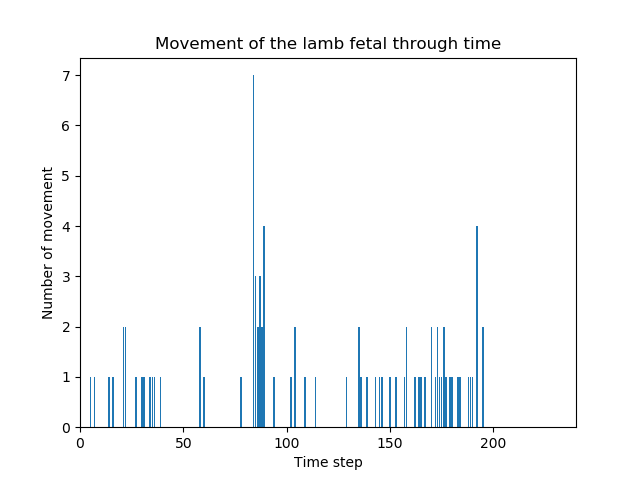

Text(0.5, 0, 'Time step')

In [6]:
plt.figure()
plt.bar(range(len(Y)), Y)
plt.title("Movement of the lamb fetal through time")
plt.xlim(0, len(Y))
plt.ylabel("Number of movement")
plt.xlabel("Time step")

# We will fit a two component poisson HMM

A 2 components poisson HMM is made of :
* A posterior `gamma` distribution over $\theta = \lambda \in IR^2$
* A posterior distribution over $S \in IR^n$, the states vector; where $n = #obs$
* A posterior `dirichlet` distribution over the transition matrix $P \in IR^{2x2}$

We start by definig the posterior of $ \lambda$

In [7]:
tDictDist = {"_lambda": gamma()}
tDictDist["_lambda"]._set_default(a = np.array([1, 2]))
tDictDist["_lambda"]._set_default(scale = np.array([1/2, 1]))

Now, the **S** distribtuion ...

In [8]:
sDist = simul_s(func = _poisson) # S distribution

Now the $P$ distribution

In [9]:
pDist = dirichlet() # A dirichlet distribution is common for probability vectors
pDist._set(a = np.array([[3,1], [0.5,0.5]]))

# Running the HMM

In [10]:
Theta = {"_lambda" : np.array([0.5, 2])} # Initial lambdas, any !
S = np.random.choice(2, len(Y)) # Initial S, random !
P = np.array([[0.75,0.25],[0.5,0.5]]) # Initial P, any !

In [11]:
phmm = HMM(tDictDist, sDist, pDist, Y=Y, S = S, Theta = Theta, P = P )

In [12]:
phmm.run(5000, historise = True) # Start the gibbs sampler n-times

## Checking for auto-correlation in the chain

<IPython.core.display.Javascript object>


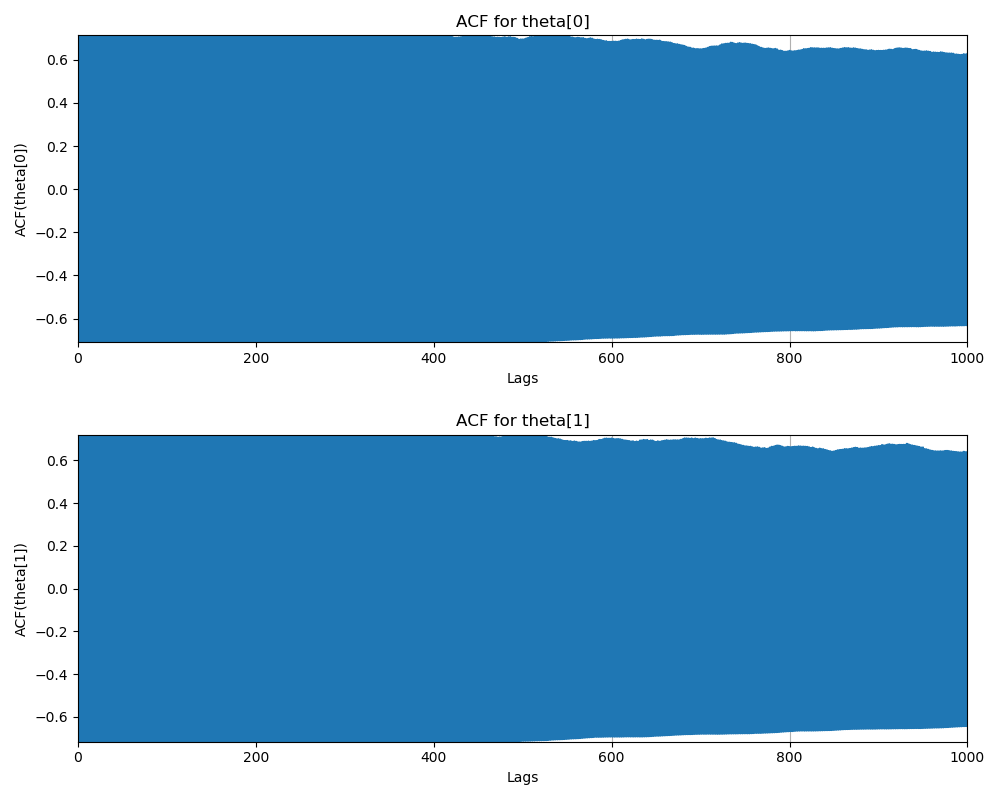

In [13]:
from utils import plot_ACF

lambdas = np.array([x["_lambda"] for x in phmm.H["Theta"]])

plot_ACF(lambdas, nlags = 1000)

The ACF is not converging toward zero. It seems the chain is not good. However, you can see below that we get the same results has in the paper. Maybe the ACF is not accurate for this model.

# Can we recover the clusters ? Let's see !

<IPython.core.display.Javascript object>


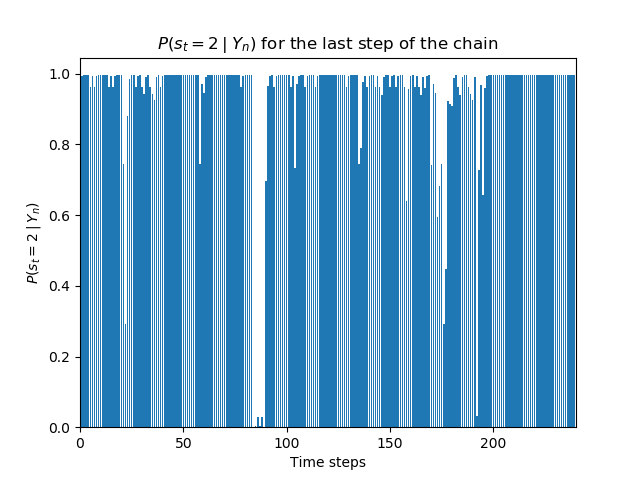

Text(0.5, 1.0, '$P(s_t = 2\\:|\\:Y_n)$ for the last step of the chain')

In [14]:
plt.figure()
plt.bar(range(sDist.F.shape[0]), sDist.F[:, 1])
plt.xlim(0, 240)
plt.ylabel("$P(s_t = 2\:|\:Y_n)$")
plt.xlabel("Time steps")
plt.title("$P(s_t = 2\:|\:Y_n)$ for the last step of the chain")

As expected, we get the same results as in the paper.

# The posteriors

## Lambdas

In [15]:
pd.DataFrame(lambdas[500:], columns = ["lambda1", "lambda2"])\
            .describe().drop("count", axis=0)

,lambda1,lambda2
mean,1.008900,1.255405
std,0.888203,1.176127
min,0.058916,0.029995
25%,0.221909,0.207797
50%,0.474999,0.514489
75%,1.716721,2.190948
max,4.211000,5.482490


## Transition probabilities (P)

In [16]:
pd.DataFrame(np.array(phmm.H["P"])[500:, [0,1], [0,1]], columns = ["p11", "p22"])\
            .describe().drop("count", axis=0)

,p11,p22
mean,0.816033,0.806328
std,0.183737,0.182390
min,0.156600,0.165880
25%,0.675930,0.667279
50%,0.908346,0.890947
75%,0.972507,0.964802
max,0.999644,0.999209


# Conclusion

We get the same results has in the paper. However it seems the ACF is not good. The chain is too much correlated. There is no way to check if it was also the case in the paper.